# Class Balancing - Traffic Accidents

This notebook explores **2 approaches** to balance the target class:
1. **Undersampling** - Reduce majority class to match minority class size
2. **SMOTE** - Synthetic Minority Over-sampling Technique

Each approach is evaluated using Naive Bayes and KNN classifiers.

In [1]:
import sys
from pandas import read_csv, DataFrame, Series, concat
from matplotlib.pyplot import figure, savefig, show
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

sys.path.insert(1, '../../../../utils')
from dslabs_functions import get_variable_types, NR_STDEV, determine_outlier_thresholds_for_var
from studies import evaluate_and_plot

In [2]:
# filename = "../../data/prepared/traffic_scaling_Standard-Scaler.csv"
# filename = "../../data/prepared/traffic_scaling_MinMax-Scaler.csv"
filename = "../../data/prepared/traffic_best_sca.csv"

In [3]:
file_tag = "traffic"
metric="f1"
lab_folder_bal = "lab3_preparation/balancing"
target_name = "crash_type"

data: DataFrame = read_csv(filename, na_values="")
variable_types: dict[str, list] = get_variable_types(data)
numeric_vars = variable_types['numeric']
input_df = data.copy(deep=True)

# # Step 1: Apply truncate outliers (best from outliers step)
# temp_df: DataFrame = data.copy(deep=True)
# summary5: DataFrame = data[numeric_vars].describe()

# for var in numeric_vars:
#     top, bottom = determine_outlier_thresholds_for_var(summary5[var])
#     temp_df[var] = temp_df[var].apply(
#         lambda x: top if x > top else bottom if x < bottom else x
#     )

# # Step 2: Apply MinMax scaling (best from scaling step)
# input_df = temp_df.copy()
# target: Series = input_df.pop(target_name)

# numeric_df = input_df[numeric_vars].copy()
# transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(numeric_df)
# numeric_df_scaled = DataFrame(transf.transform(numeric_df), index=input_df.index)
# input_df[numeric_vars] = numeric_df_scaled
# input_df[target_name] = target

print(f"Dataset shape: {input_df.shape}")
print(f"\nClass distribution before balancing:")
print(input_df[target_name].value_counts())
print(f"Ratio: {input_df[target_name].value_counts()[0] / input_df[target_name].value_counts()[1]:.2f}:1")

Dataset shape: (209306, 150)

Class distribution before balancing:
crash_type
0    117376
1     91930
Name: count, dtype: int64
Ratio: 1.28:1


## Approach 1: Undersampling

Randomly reduce the majority class to match the minority class size.

In [4]:
approach_bal1 = "undersampling"

# Separate majority and minority classes
df_majority = input_df[input_df[target_name] == 0]
df_minority = input_df[input_df[target_name] == 1]

print(f"Majority class (0): {len(df_majority)} records")
print(f"Minority class (1): {len(df_minority)} records")

# Undersample majority class to match minority class size
df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42)

# Combine minority class with undersampled majority class
data_bal1 = concat([df_majority_undersampled, df_minority])

# Shuffle the dataset
data_bal1 = data_bal1.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nClass distribution after undersampling:")
print(data_bal1[target_name].value_counts())
print(f"Dataset size: {len(input_df)} → {len(data_bal1)} ({100*len(data_bal1)/len(input_df):.1f}%)")

Majority class (0): 117376 records
Minority class (1): 91930 records

Class distribution after undersampling:
crash_type
1    91930
0    91930
Name: count, dtype: int64
Dataset size: 209306 → 183860 (87.8%)


## Approach 2: SMOTE (Synthetic Minority Over-sampling Technique)

Generate synthetic samples for the minority class using k-nearest neighbors.

In [5]:
approach_bal2 = "SMOTE"

# Separate features and target
X = input_df.drop(columns=[target_name])
y = input_df[target_name]

print(f"Original class distribution:")
print(y.value_counts())

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine back into DataFrame
data_bal2 = DataFrame(X_resampled, columns=X.columns)
data_bal2[target_name] = y_resampled

print(f"\nClass distribution after SMOTE:")
print(data_bal2[target_name].value_counts())
print(f"Dataset size: {len(input_df)} → {len(data_bal2)} ({100*len(data_bal2)/len(input_df):.1f}%)")

Original class distribution:
crash_type
0    117376
1     91930
Name: count, dtype: int64

Class distribution after SMOTE:
crash_type
0    117376
1    117376
Name: count, dtype: int64
Dataset size: 209306 → 234752 (112.2%)


## Evaluate

Couldn't run MultinomialNB


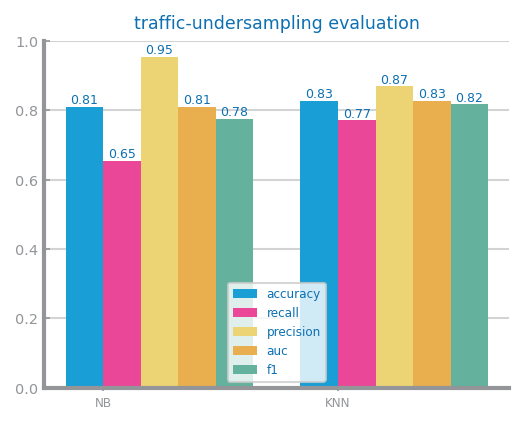

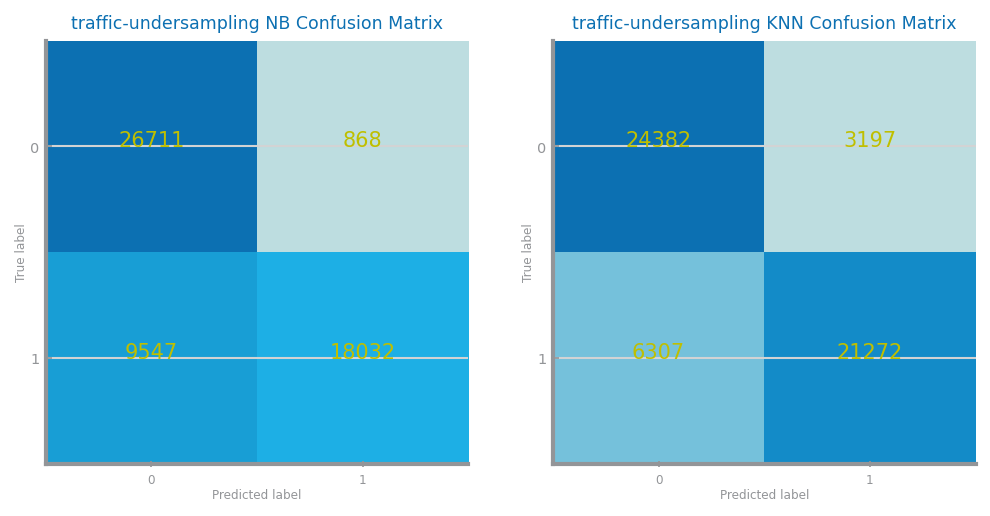

In [6]:
evaluate_and_plot(data_bal1, lab_folder_bal, file_tag, approach_bal1, target_name, metric=metric)

Couldn't run MultinomialNB


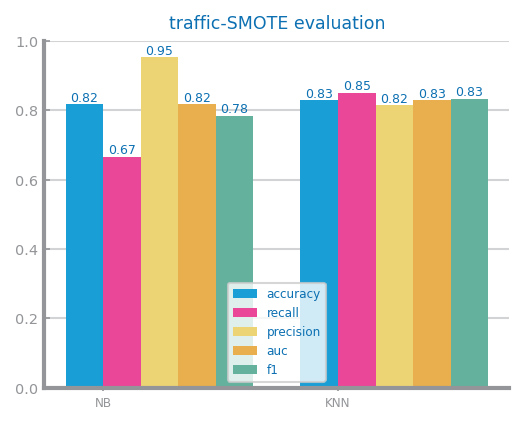

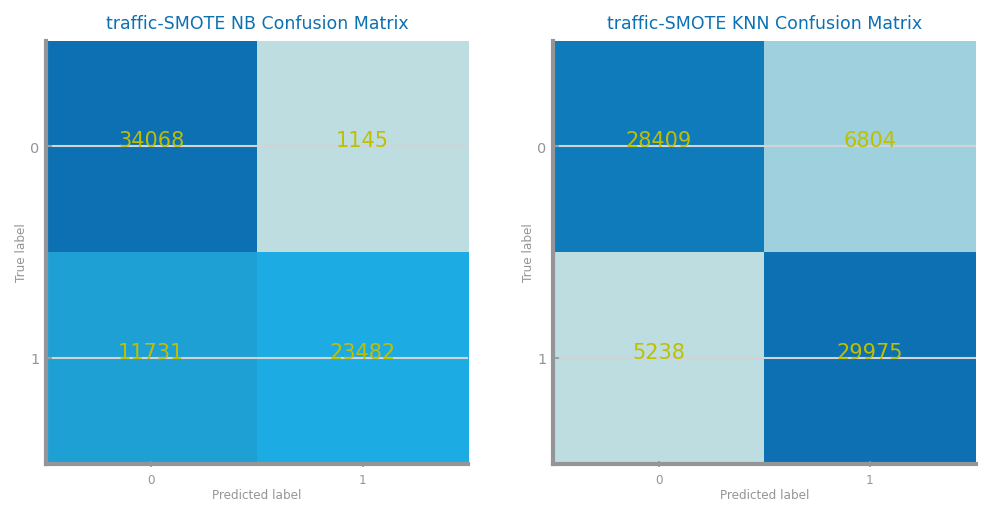

In [7]:
evaluate_and_plot(data_bal2, lab_folder_bal, file_tag, approach_bal2, target_name, metric=metric)

## Save Best Result

Based on evaluation metrics, save the best performing approach.

In [8]:
# Uncomment to save individual results
data_bal1.to_csv(f"../../data/prepared/{file_tag}_balancing_{approach_bal1}.csv", index=False)
data_bal2.to_csv(f"../../data/prepared/{file_tag}_balancing_{approach_bal2}.csv", index=False)

# approach 2 was best knn
best_df_bal = data_bal2.copy()
best_approach_bal = approach_bal2
best_df_bal.to_csv(f"../../data/prepared/traffic_best_bal.csv", index=False)
print(f"Best approach: {best_approach_bal}")
print(f"Shape: {best_df_bal.shape}")

Best approach: SMOTE
Shape: (234752, 150)
